In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [2]:
# Step 1: Preprocess the dataset
data_dir = "B16_specs_proc_new/"
emotions_to_consider = ["happy", "sad", "angry", "neutral"]

# Load images and labels
images = []
labels = []

In [3]:
for emotion in emotions_to_consider:
    emotion_dir = os.path.join(data_dir, emotion)
    for img_name in os.listdir(emotion_dir):
        img = load_img(os.path.join(emotion_dir, img_name), target_size=(224, 224))
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(emotion)

In [4]:
# Convert to numpy arrays and normalize
images = np.array(images) / 255.0
labels = np.array(labels)

# Encode labels
label_to_index = {label: idx for idx, label in enumerate(emotions_to_consider)}
index_to_label = {idx: label for label, idx in label_to_index.items()}
labels = np.array([label_to_index[label] for label in labels])

In [5]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [6]:
# Step 2: Build the VGGNet model
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [7]:
# Step 3: Train the model
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

batch_size = 32
epochs = 50

In [8]:
# Train the model
checkpoint = ModelCheckpoint("V:/modelVGG_B16_procN.h5", save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=[checkpoint]
)

Epoch 1/50
13/13 [==============================] - 199s 15s/step - loss: 1.3895 - accuracy: 0.2512 - val_loss: 1.3924 - val_accuracy: 0.1875
Epoch 2/50
13/13 [==============================] - 114s 9s/step - loss: 1.3988 - accuracy: 0.2778 - val_loss: 1.4311 - val_accuracy: 0.1875
Epoch 3/50
13/13 [==============================] - 162s 13s/step - loss: 1.3851 - accuracy: 0.2995 - val_loss: 1.3858 - val_accuracy: 0.2679
Epoch 4/50
13/13 [==============================] - 159s 13s/step - loss: 1.3858 - accuracy: 0.2585 - val_loss: 1.3853 - val_accuracy: 0.2768
Epoch 5/50
13/13 [==============================] - 158s 13s/step - loss: 1.3851 - accuracy: 0.2826 - val_loss: 1.3851 - val_accuracy: 0.3214
Epoch 6/50
13/13 [==============================] - 115s 9s/step - loss: 1.3826 - accuracy: 0.3261 - val_loss: 1.3912 - val_accuracy: 0.2054
Epoch 7/50
13/13 [==============================] - 160s 13s/step - loss: 1.3618 - accuracy: 0.2850 - val_loss: 1.3765 - val_accuracy: 0.2589
Epoch 8/

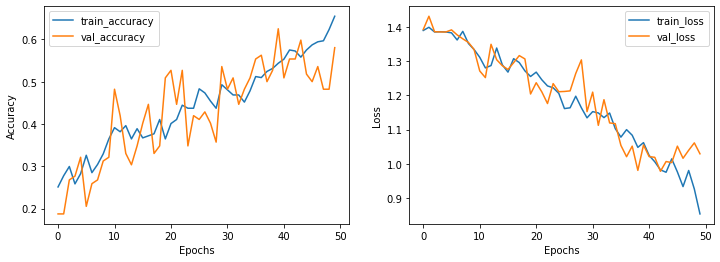

In [9]:
# Step 4: Evaluate the model
# Plot the accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [10]:
# Evaluate the best model on the test set
model.load_weights("V:/modelVGG_B16_procN.h5")
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")
print(f"Test loss: {test_loss:.2f}")

4/4 [==============================] - 7s 2s/step - loss: 0.9783 - accuracy: 0.5536
Test accuracy: 0.55
Test loss: 0.98


In [11]:
from sklearn.metrics import confusion_matrix, classification_report

# Get the predicted labels
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)

# Calculate per-emotion accuracy and other metrics
report = classification_report(y_test, y_pred_labels, target_names=emotions_to_consider, digits=2)
print("\nClassification Report:")
print(report)

4/4 [==============================] - 7s 2s/step
Confusion Matrix:
[[22  6  4  3]
 [ 5 15  1  8]
 [ 6  4  8  3]
 [ 0  7  3 17]]

Classification Report:
              precision    recall  f1-score   support

       happy       0.67      0.63      0.65        35
         sad       0.47      0.52      0.49        29
       angry       0.50      0.38      0.43        21
     neutral       0.55      0.63      0.59        27

    accuracy                           0.55       112
   macro avg       0.55      0.54      0.54       112
weighted avg       0.56      0.55      0.55       112



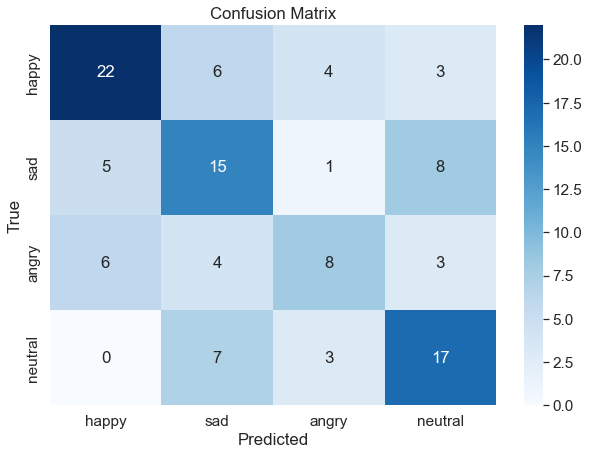

In [14]:
import seaborn as sns

# Create a colorful confusion matrix with labels
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4)  # Set font scale for better readability
cm = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=emotions_to_consider, yticklabels=emotions_to_consider)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

AttributeError: 'AxesSubplot' object has no attribute 'diagonal'